## 2.9 Feature engineering


The process of feature engineering is of manipulating, transforming, and selecting raw data into features that can be used in statistical analysis of prediction.

* statistical features
* temporal features
* spectral features (Fourier and Wavelet transforms)

This lecture will demonstrate how to automatically extract features from a popular (but simple) Python package ``tsfel`` to extract common features of time series. We will take the example of seismic waveforms recorded in the Pacific Northwest. The Pacific Northwest data detect and labels seismic waveforms for event of various origins: earthquake, explosions (mostly quarry blasts), and surface events (usually avalanches and landslides), but also seismic noise (ambient Earth vibrations in between).

We will explore how these features vary among the four categories, or classes of seismic events.

[Level 1]

In [1]:
# Import modules for seismic data and feature extraction

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import scipy.stats as st
import os
import h5py # for reading .h5 files

In [2]:
#make sure to install wget
!pip install wget
import wget

  Using cached wget-3.2-py3-none-any.whl


We download 2 files from the class storage: a CSV file with the waveforms themselves as an HDF5 file and their associated metadata as a CSV file:

In [3]:
wget.download("https://www.dropbox.com/s/f0e1ywupdbuv3l3/miniPNW_metadata.csv?dl=1")
wget.download("https://www.dropbox.com/s/0ffh4r23mitn2dz/miniPNW_waveforms.hdf5?dl=1")
# os.replace("miniPNW_metadata.csv","../../miniPNW_metadata.csv")
# os.replace("miniPNW_waveforms.hdf5","../../miniPNW_waveforms.hdf5")

'miniPNW_waveforms.hdf5'

## Metadata

We first read the metadata and arange them into a Pandas Data frame

In [4]:
# plot the time series
df = pd.read_csv("miniPNW_metadata.csv")
df.head()


,Unnamed: 0,event_id,source_origin_time,source_latitude_deg,source_longitude_deg,source_type,source_depth_km,preferred_source_magnitude,preferred_source_magnitude_type,preferred_source_magnitude_uncertainty,...,trace_S_onset,trace_P_onset,trace_snr_db,year,source_type_pnsn_label,source_local_magnitude,source_local_magnitude_uncertainty,source_duration_magnitude,source_duration_magnitude_uncertainty,source_hand_magnitude
0,0,uw61669232,2020-09-07T03:44:14.690000Z,46.560,-119.797,earthquake,23.300,1.30,ml,0.241000,...,impulsive,impulsive,-1.444|2.612|9.921,2020.0,eq,1.30,0.241273,1.17,0.187840,NaN
1,1,uw60888282,2014-10-08T15:39:31.330000Z,45.371,-121.708,earthquake,-0.947,1.67,ml,0.128000,...,impulsive,impulsive,0.368|3.526|5.981,2014.0,eq,1.67,0.128000,1.63,0.099000,NaN
2,2,uw61361706,2017-12-30T04:37:46.870000Z,46.165,-120.543,earthquake,13.520,2.46,ml,0.158000,...,impulsive,emergent,11.274|13.32|15.828,2017.0,eq,2.46,0.158000,3.37,0.389000,NaN
3,3,uw61639436,2020-06-09T23:37:10.420000Z,46.542,-119.589,earthquake,16.370,1.59,ml,0.157000,...,impulsive,emergent,27.007|20.797|19.252,2020.0,eq,1.59,0.156750,1.69,0.354773,NaN
4,4,uw61735446,2021-05-24T10:42:37.810000Z,46.857,-121.941,earthquake,12.380,0.83,ml,0.082983,...,impulsive,emergent,18.579|18.912|7.609,2021.0,eq,0.83,0.082983,0.50,0.381880,NaN


The nature of the event source is located in one of the metadata attributes

In [5]:
df['source_type'].unique()

array(['earthquake', 'explosion', 'sonic_boom', 'thunder',
       'surface_event'], dtype=object)

Let's assume that we are exploring features to classify the waveforms into the categories of the event types. We will attribute the **labels* as the ``source_type`` attribute.

In [6]:
labels=df['source_type']

How many seismic waveforms are there in each of the category?

In [18]:
df.groupby('source_type').count()['event_id']

source_type
earthquake       500
explosion        500
sonic_boom       126
surface_event    500
thunder           94
Name: event_id, dtype: int64

Would you say that this is a balanced data set with respect to the four classes of interest?

Now we will look at the seismic data, taking a random waveform from each of the categories

(array([500.,   0., 500.,   0.,   0., 126.,   0.,  94.,   0., 500.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

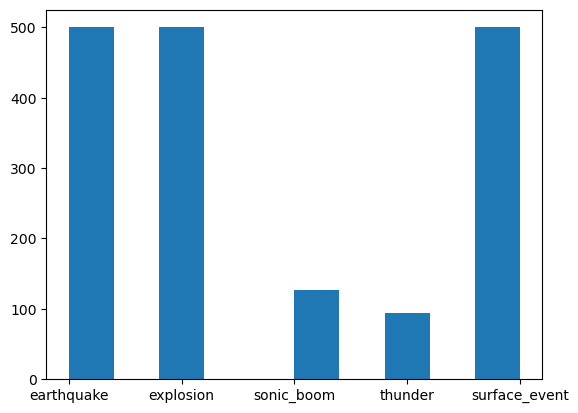

In [19]:
plt.hist(labels)

Now are read the data. It is stored in an HDF5 files under a finite number of groups. Each groups has an array of datasets that correspond to the waveforms. To link the metadata to the waveform files, the key trace_name has the dataset ID. The address is labeled as follows:
```
bucketX$i,:3,:n
```

where ``X`` is the HDF5 group number, ``i`` is the index. The file has typically 3 waveforms from each direction of ground motions N, E, Z. In the following exercise, we will focus on the vertical waveforms.

In [12]:
f = h5py.File("miniPNW_waveforms.hdf5", "r")

Below a function to read the file in the data

In [20]:
def read_data(tn,f):
    bucket, narray = tn.split('$')  # split the string of trace_name into bucket and narray
    x, y, z = iter([int(i) for i in narray.split(',:')]) # split thenarray into x, y, z
    data = f['/data/%s' % bucket][x, :y, :z] # read the data as a 3D array
    return data

The trace name is stored as data attriobute in the metadata.

In [21]:
ldata=list(df['trace_name'])

(3, 15001)


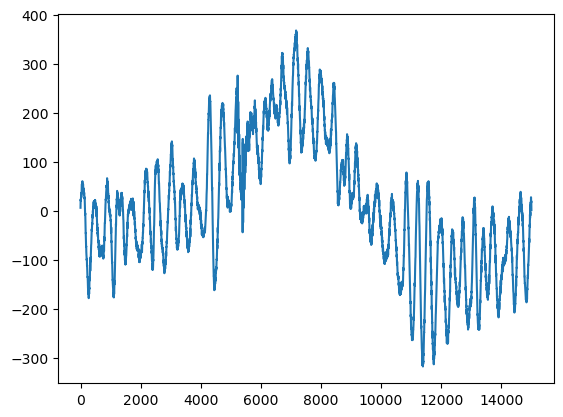

In [41]:
crap=read_data(ldata[400],f)
print(crap.shape)
plt.plot(crap[1,:])

We will just extract the Z component and reshape them into a single array.

In [24]:
nt=crap.shape[-1]
ndata=len(labels)
Z=np.zeros(shape=(ndata,nt))
for i in range(ndata-1):
    Z[i,:]=read_data(df.iloc[i]["trace_name"],f)[2,:nt]

Now we have data and its attributes, in particular the label as source type.

We are going to extract features automatically from tsfel and explore how varied the

In [25]:
!pip install tsfel
import tsfel

     |████████████████████████████████| 42 kB 1.3 MB/s eta 0:00:011
     |████████████████████████████████| 12.4 MB 15.0 MB/s eta 0:00:01
     |████████████████████████████████| 341 kB 75.8 MB/s eta 0:00:01
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.2
    Uninstalling pandas-1.5.2:
      Successfully uninstalled pandas-1.5.2


We need to format for input into tsfresh. It needs 1 column with the ``id`` (or label), one column for the time stamps (``sort``)

In [26]:
cfg = tsfel.get_features_by_domain()     

In [31]:
for i in range(100):#Z.shape[0]):
    print(i/Z.shape[0])
    if i==0:
        X=tsfel.time_series_features_extractor(cfg, Z[i,:],fs=100.,)
        X['source_type']=df.iloc[i]['source_type']
    else:
        XX = tsfel.time_series_features_extractor(cfg, Z[i,:],fs=100.,)
        XX['source_type']=df.iloc[i]['source_type']
        X=pd.concat([XX,X],axis=0,ignore_index=True)


0.0
*** Feature extraction started ***



*** Feature extraction finished ***
0.0005813953488372093
*** Feature extraction started ***



*** Feature extraction finished ***
0.0011627906976744186
*** Feature extraction started ***



*** Feature extraction finished ***
0.0017441860465116279
*** Feature extraction started ***



*** Feature extraction finished ***
0.002325581395348837
*** Feature extraction started ***



*** Feature extraction finished ***
0.0029069767441860465
*** Feature extraction started ***



*** Feature extraction finished ***
0.0034883720930232558
*** Feature extraction started ***



*** Feature extraction finished ***
0.004069767441860465
*** Feature extraction started ***



*** Feature extraction finished ***
0.004651162790697674
*** Feature extraction started ***



*** Feature extraction finished ***
0.005232558139534884
*** Feature extraction started ***



*** Feature extraction finished ***
0.005813953488372093
*** Feature extraction started ***



*** Feature extraction finished ***
0.006395348837209302
*** Feature extraction started ***



*** Feature extraction finished ***
0.0069767441860465115
*** Feature extraction started ***



*** Feature extraction finished ***
0.007558139534883721
*** Feature extraction started ***



*** Feature extraction finished ***
0.00813953488372093
*** Feature extraction started ***



*** Feature extraction finished ***
0.00872093023255814
*** Feature extraction started ***



*** Feature extraction finished ***
0.009302325581395349
*** Feature extraction started ***



*** Feature extraction finished ***
0.009883720930232558
*** Feature extraction started ***



*** Feature extraction finished ***
0.010465116279069767
*** Feature extraction started ***



*** Feature extraction finished ***
0.011046511627906977
*** Feature extraction started ***



*** Feature extraction finished ***
0.011627906976744186
*** Feature extraction started ***



*** Feature extraction finished ***
0.012209302325581395
*** Feature extraction started ***



*** Feature extraction finished ***
0.012790697674418604
*** Feature extraction started ***



*** Feature extraction finished ***
0.013372093023255814
*** Feature extraction started ***



*** Feature extraction finished ***
0.013953488372093023
*** Feature extraction started ***



*** Feature extraction finished ***
0.014534883720930232
*** Feature extraction started ***



*** Feature extraction finished ***
0.015116279069767442
*** Feature extraction started ***



*** Feature extraction finished ***
0.015697674418604653
*** Feature extraction started ***



*** Feature extraction finished ***
0.01627906976744186
*** Feature extraction started ***



*** Feature extraction finished ***
0.01686046511627907
*** Feature extraction started ***



*** Feature extraction finished ***
0.01744186046511628
*** Feature extraction started ***



*** Feature extraction finished ***
0.01802325581395349
*** Feature extraction started ***



*** Feature extraction finished ***
0.018604651162790697
*** Feature extraction started ***



*** Feature extraction finished ***
0.01918604651162791
*** Feature extraction started ***



*** Feature extraction finished ***
0.019767441860465116
*** Feature extraction started ***



*** Feature extraction finished ***
0.020348837209302327
*** Feature extraction started ***



*** Feature extraction finished ***
0.020930232558139535
*** Feature extraction started ***



*** Feature extraction finished ***
0.021511627906976746
*** Feature extraction started ***



*** Feature extraction finished ***
0.022093023255813953
*** Feature extraction started ***



*** Feature extraction finished ***
0.022674418604651164
*** Feature extraction started ***



*** Feature extraction finished ***
0.023255813953488372
*** Feature extraction started ***



*** Feature extraction finished ***
0.023837209302325583
*** Feature extraction started ***



*** Feature extraction finished ***
0.02441860465116279
*** Feature extraction started ***



*** Feature extraction finished ***
0.025
*** Feature extraction started ***



*** Feature extraction finished ***
0.02558139534883721
*** Feature extraction started ***



*** Feature extraction finished ***
0.02616279069767442
*** Feature extraction started ***



*** Feature extraction finished ***
0.026744186046511628
*** Feature extraction started ***



*** Feature extraction finished ***
0.02732558139534884
*** Feature extraction started ***



*** Feature extraction finished ***
0.027906976744186046
*** Feature extraction started ***



*** Feature extraction finished ***
0.028488372093023257
*** Feature extraction started ***



*** Feature extraction finished ***
0.029069767441860465
*** Feature extraction started ***



*** Feature extraction finished ***
0.029651162790697676
*** Feature extraction started ***



*** Feature extraction finished ***
0.030232558139534883
*** Feature extraction started ***



*** Feature extraction finished ***
0.030813953488372094
*** Feature extraction started ***



*** Feature extraction finished ***
0.031395348837209305
*** Feature extraction started ***



*** Feature extraction finished ***
0.03197674418604651
*** Feature extraction started ***



*** Feature extraction finished ***
0.03255813953488372
*** Feature extraction started ***



*** Feature extraction finished ***
0.03313953488372093
*** Feature extraction started ***



*** Feature extraction finished ***
0.03372093023255814
*** Feature extraction started ***



*** Feature extraction finished ***
0.03430232558139535
*** Feature extraction started ***



*** Feature extraction finished ***
0.03488372093023256
*** Feature extraction started ***



*** Feature extraction finished ***
0.035465116279069765
*** Feature extraction started ***



*** Feature extraction finished ***
0.03604651162790698
*** Feature extraction started ***



*** Feature extraction finished ***
0.03662790697674419
*** Feature extraction started ***



*** Feature extraction finished ***
0.037209302325581395
*** Feature extraction started ***



*** Feature extraction finished ***
0.0377906976744186
*** Feature extraction started ***



*** Feature extraction finished ***
0.03837209302325582
*** Feature extraction started ***



*** Feature extraction finished ***
0.038953488372093024
*** Feature extraction started ***



*** Feature extraction finished ***
0.03953488372093023
*** Feature extraction started ***



*** Feature extraction finished ***
0.04011627906976744
*** Feature extraction started ***



*** Feature extraction finished ***
0.040697674418604654
*** Feature extraction started ***



*** Feature extraction finished ***
0.04127906976744186
*** Feature extraction started ***



*** Feature extraction finished ***
0.04186046511627907
*** Feature extraction started ***



*** Feature extraction finished ***
0.04244186046511628
*** Feature extraction started ***



*** Feature extraction finished ***
0.04302325581395349
*** Feature extraction started ***



*** Feature extraction finished ***
0.0436046511627907
*** Feature extraction started ***



*** Feature extraction finished ***
0.044186046511627906
*** Feature extraction started ***



*** Feature extraction finished ***
0.044767441860465114
*** Feature extraction started ***



*** Feature extraction finished ***
0.04534883720930233
*** Feature extraction started ***



*** Feature extraction finished ***
0.045930232558139536
*** Feature extraction started ***



*** Feature extraction finished ***
0.046511627906976744
*** Feature extraction started ***



*** Feature extraction finished ***
0.04709302325581395
*** Feature extraction started ***



*** Feature extraction finished ***
0.047674418604651166
*** Feature extraction started ***



*** Feature extraction finished ***
0.04825581395348837
*** Feature extraction started ***



*** Feature extraction finished ***
0.04883720930232558
*** Feature extraction started ***



*** Feature extraction finished ***
0.04941860465116279
*** Feature extraction started ***



*** Feature extraction finished ***
0.05
*** Feature extraction started ***



*** Feature extraction finished ***
0.05058139534883721
*** Feature extraction started ***



*** Feature extraction finished ***
0.05116279069767442
*** Feature extraction started ***



*** Feature extraction finished ***
0.051744186046511625
*** Feature extraction started ***



*** Feature extraction finished ***
0.05232558139534884
*** Feature extraction started ***



*** Feature extraction finished ***
0.05290697674418605
*** Feature extraction started ***



*** Feature extraction finished ***
0.053488372093023255
*** Feature extraction started ***



*** Feature extraction finished ***
0.05406976744186046
*** Feature extraction started ***



*** Feature extraction finished ***
0.05465116279069768
*** Feature extraction started ***



*** Feature extraction finished ***
0.055232558139534885
*** Feature extraction started ***



*** Feature extraction finished ***
0.05581395348837209
*** Feature extraction started ***



*** Feature extraction finished ***
0.0563953488372093
*** Feature extraction started ***



*** Feature extraction finished ***
0.056976744186046514
*** Feature extraction started ***



*** Feature extraction finished ***
0.05755813953488372
*** Feature extraction started ***



*** Feature extraction finished ***


In [48]:
X['source_type']

0     earthquake
1     earthquake
2     earthquake
3     earthquake
4     earthquake
         ...    
95    earthquake
96    earthquake
97    earthquake
98    earthquake
99    earthquake
Name: source_type, Length: 100, dtype: object

## Exploring the feature space

Here we will plot distributions of features among the four classes. And we will explore what features are most correlated with each others in each of the categories.


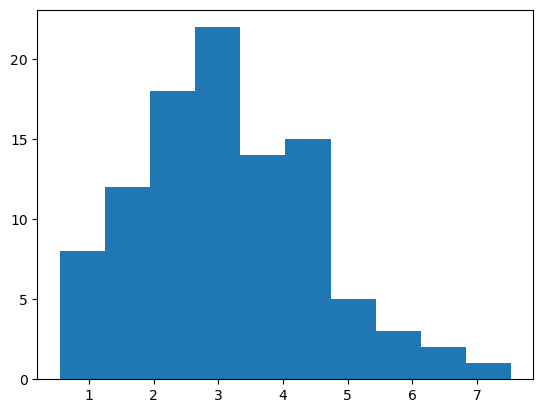

In [38]:
plt.hist(np.log10(X['0_Wavelet variance_1']));

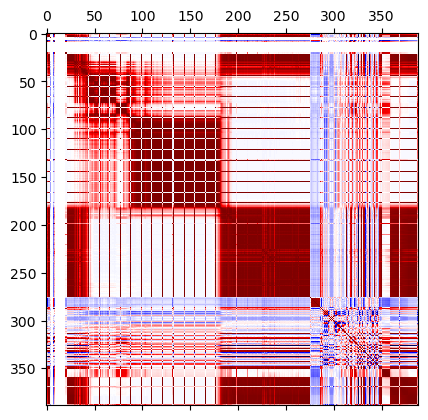

In [39]:
plt.matshow(X.drop('source_type',axis=1).corr(),cmap='seismic',vmin=-1,vmax=1)

In [84]:
df_corr = X.drop('source_type',axis=1).corr().abs()
# Select upper triangle of correlation matrix
upper = df_corr.where(np.triu(np.ones(df_corr.shape), k=1).astype(bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.6)]

# Drop features 
df2 = X.drop(to_drop, axis=1)


Now calculate features for 100 events of each category and find features that differ from each other.

You may 1) calculate all features, 2) plot histograms/distributions of each feature and overlay each source-specific feature, 3) report on the ones that look different between each class and propose a workflow to classify between event types.

/tmp/ipykernel_134/1665686108.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  plt.matshow(df2.corr(),cmap='seismic',vmin=-1,vmax=1)


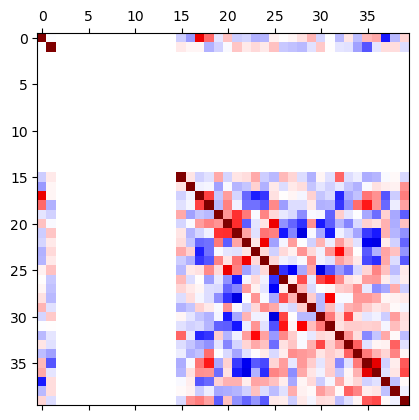

In [85]:
plt.matshow(df2.corr(),cmap='seismic',vmin=-1,vmax=1)

In [71]:
X

,0_Absolute energy,0_Area under the curve,0_Centroid,0_ECDF Percentile Count_0,0_ECDF Percentile Count_1,0_ECDF_0,0_ECDF_1,0_ECDF_2,0_ECDF_3,0_ECDF_4,...,0_Median diff,0_Median frequency,0_Neighbourhood peaks,0_Skewness,0_Slope,0_Spectral decrease,0_Spectral entropy,0_Spectral kurtosis,0_Spectral variation,source_type
0,2.230611e+08,14991.073242,76.798453,3000.0,12000.0,0.000067,0.000133,0.0002,0.000267,0.000333,...,-0.041891,0.246650,166.0,0.279337,0.012025,-0.151578,0.386131,21.756239,0.277123,earthquake
1,2.488356e+07,4871.707624,68.967313,3000.0,12000.0,0.000067,0.000133,0.0002,0.000267,0.000333,...,0.002759,2.753150,447.0,-0.347556,0.002493,-0.029807,0.453694,5.448594,0.182124,earthquake
2,3.639245e+09,60183.988650,68.295305,3000.0,12000.0,0.000067,0.000133,0.0002,0.000267,0.000333,...,0.135729,0.239984,91.0,-0.064656,-0.015664,-0.319149,0.318109,30.869948,0.280984,earthquake
3,3.538010e+08,18827.685410,83.624318,3000.0,12000.0,0.000067,0.000133,0.0002,0.000267,0.000333,...,0.004887,3.366442,418.0,0.078108,0.005526,-0.195467,0.317563,5.310117,0.180846,earthquake
4,1.378592e+10,111330.005487,57.429298,3000.0,12000.0,0.000067,0.000133,0.0002,0.000267,0.000333,...,1.069024,5.019665,444.0,-0.238128,0.078878,-0.287599,0.423950,3.606467,0.156862,earthquake
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,6.311266e+07,7488.112297,48.302529,3000.0,12000.0,0.000067,0.000133,0.0002,0.000267,0.000333,...,-0.007477,4.366376,234.0,0.229819,-0.009184,-0.288857,0.393085,2.407195,0.093856,earthquake
96,1.551697e+08,9323.907442,61.474693,3000.0,12000.0,0.000067,0.000133,0.0002,0.000267,0.000333,...,0.007396,6.252916,574.0,-1.302235,0.007589,-0.045427,0.718425,4.958035,0.066683,earthquake
97,6.680359e+08,22764.856447,83.784243,3000.0,12000.0,0.000067,0.000133,0.0002,0.000267,0.000333,...,0.004482,3.306446,382.0,-0.072928,0.004889,-0.006895,0.635212,11.336931,0.129115,earthquake
98,3.551557e+08,18832.758199,85.292174,3000.0,12000.0,0.000067,0.000133,0.0002,0.000267,0.000333,...,-0.066968,1.459903,292.0,-0.001329,-0.008452,-0.294880,0.406640,5.296116,0.282548,earthquake
